In [1]:
pip install giotto-tda

Note: you may need to restart the kernel to use updated packages.


In [2]:
#generación de datos:
from gtda.time_series import SingleTakensEmbedding
import numpy as np
from scipy.signal import chirp, resample
import random
from gtda.plotting import plot_point_cloud

In [3]:
# Parámetros de configuración para señal y ruido
sample_rate = 2048 # Frecuencia de muestreo en Hz
signal_duration = 2 # Duración de la señal en segundos
noise_duration = 0.976 # Duración del ruido en segundos
num_signals = 1500 # Número de señales a generar
mass_ratio_min = 1.0078 # Valor mínimo de la relación de masas
mass_ratio_max = 9.9759 # Valor máximo de la relación de masas
R_min = 0.075 # Valor mínimo del coeficiente R
R_max = 0.65 # Valor máximo del coeficiente R


In [4]:
# Generación de señales de referencia
mass_ratios = np.random.uniform(mass_ratio_min, mass_ratio_max, num_signals) # Generar relaciones de masa aleatorias
reference_signals = []
for mass_ratio in mass_ratios:
  time = np.linspace(0, signal_duration, sample_rate * signal_duration, endpoint=False) # Generar vector de tiempo
  signal = chirp(time, f0=10, f1=100, t1=signal_duration, method='linear') # Crear señal de chirp
  reference_signals.append(signal) # Añadir señal generada a la lista de señales de referencia

# Función para insertar la señal en ruido
def insert_signal_in_noise(signal, noise_duration):
  noise = np.random.normal(0, 0.5, int(sample_rate * noise_duration)) # Generar ruido con distribución normal
  start_time = random.uniform(0, noise_duration) # Seleccionar un tiempo de inicio aleatorio dentro del ruido
  end_time = start_time + signal_duration # Calcular el tiempo de finalización de la señal en el ruido
  full_signal = np.concatenate([noise[:int(start_time * sample_rate)], signal, noise[int(end_time * sample_rate):]]) # Concatenar ruido y señal
  return full_signal, start_time # Retornar señal completa y tiempo de inicio

In [5]:
# Generación del conjunto de datos de entrenamiento
training_data = []
for signal in reference_signals:
  R = np.random.uniform(R_min, R_max) # Seleccionar un valor aleatorio para el coeficiente R
  presence = random.random() < 0.5 # Determinar presencia de la señal con probabilidad del 50%
  if presence:
    signal_in_noise, start_time = insert_signal_in_noise(signal, noise_duration) # Insertar señal en ruido
    training_data.append((signal_in_noise, R, start_time)) # Añadir datos de entrenamiento a la lista

# Guardar los datos de entrenamiento si es necesario
for i, (signal_in_noise, R, start_time) in enumerate(training_data):
  np.savetxt(f'signal_{i}.csv', signal_in_noise, delimiter=',') # Guardar señal en archivo CSV
  with open(f'R_{i}.txt', 'w') as file:
    file.write(str(R)) # Guardar valor de R en archivo de texto
  with open(f'start_time_{i}.txt', 'w') as file:
    file.write(str(start_time)) # Guardar tiempo de inicio en archivo de texto

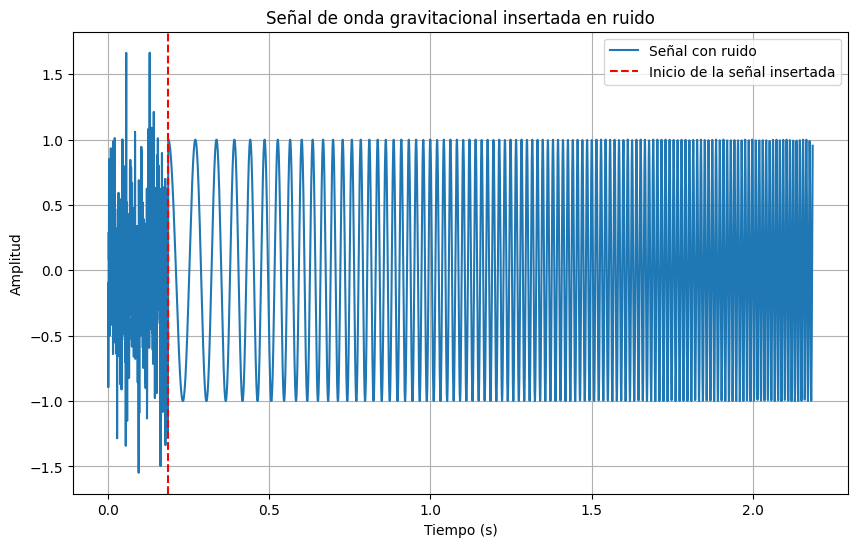

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar una señal de ejemplo (modifica el número según la señal que quieras graficar)
signal_data = np.loadtxt('signal_0.csv', delimiter=',')
R_value = float(open('R_0.txt', 'r').readline())
start_time = float(open('start_time_0.txt', 'r').readline())

# Crear vector de tiempo para la señal
sample_rate = 2048
time = np.arange(0, len(signal_data) / sample_rate, 1 / sample_rate)

# Graficar la señal
plt.figure(figsize=(10, 6))
plt.plot(time, signal_data, label='Señal con ruido')
plt.axvline(start_time, color='red', linestyle='--', label='Inicio de la señal insertada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal de onda gravitacional insertada en ruido')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Configuración de parámetros para la ventana deslizante
max_embedding_dimension_periodic = 3
max_embedding_time_delay_periodic = 10
stride = 1

# Crear el objeto de embebido con los parámetros especificados
embedder_periodic = SingleTakensEmbedding(
    parameters_type="search",
    n_jobs=3,
    time_delay=max_embedding_time_delay_periodic,
    dimension=max_embedding_dimension_periodic,
    stride=stride,
)

# Aplicar el embebido a los datos de la señal
y_periodic_embedded = embedder_periodic.fit_transform(signal_data)

# Graficar la nube de puntos embebidos
plot_point_cloud(y_periodic_embedded)